In [2]:
from motif_search_main import load_network_from_args
from utils.export_import import import_results
from utils.logs import log_motif_criteria_args, log_motif_results, log_sub_graph_args, log_randomizer_args, log_motifs_table
from utils.types import MotifCriteriaArgs, MotifType, MotifName, Motif
import matplotlib.pyplot as plt
import networkx as nx
from typing import Union
import numpy as np
from collections import defaultdict
from isomorphic.isomorphic import get_sub_graph_mapping_to_motif
from post_motif_analysis.network_utils import draw_sub_graph, draw_neighbors, node_properties


In [3]:
# data = import_results('results/cook_si2_herm_chem_k3_m5.bin')
data = import_results('results/pol_k3_m5.bin')
# data = import_results('results/cmpx_pol_k3_m5.bin')


# k = 4
# data = import_results('results/cook_si2_herm_chem_k4_m5.bin')
# data = import_results('results/durbin_herm_chem_k4_m5.bin')
# data = import_results('results/pol_k4_m10.bin')


# all: chem + gap
# data = import_results('results/cook_si2_herm_all_k3_m5.bin') # feed forward isnt a motif! (but makes sense due to gap + chem)
# data = import_results('results/cook_si2_herm_gap_k3_m5.bin') # feed forward isnt a motif! (but makes sense due to gap + chem)

# k =5
# data = import_results('results/cook_si2_herm_chem_k5_m10.bin')
# data = import_results('results/cook_si2_herm_all_k5_m10.bin')

# data = import_results('results/durbin_herm_chem_k3_m5.bin')

args = data['args']
motifs = data['motifs']

if args.input_network_file.startswith('../'):
    args.input_network_file = "/".join(args.input_network_file.strip("/").split('/')[1:])

network = load_network_from_args(args)

log_motif_criteria_args(MotifCriteriaArgs(**vars(args)))
log_sub_graph_args(args)
log_randomizer_args(args)
log_motif_results(motifs)
for motif in motifs.values():
    log_motifs_table([m for m in motif.polarity_motifs if m.motif_criteria.is_motif != MotifType.none])

Network file name: s1_data.xlsx
Filtering Neurons with polarity: ['+', '-']
Filtering Neurons with primary neurotransmitter: ['Glu', 'GABA', 'ACh', 0]
Polarity ratios (before filtering): Counter({'+': 0.757420091324201, '-': 0.2425799086757991})

Network properties:
	Neurons in the network: 283
	Participating Neurons (in the graph): 283

	Participating Nodes are neurons with at least: 5 synapses
	Synapses in the network: 11650
	Synapses in the graph: 9515
	Gaps in the network: 0
	Gaps in the graph: 0
	Nodes: 259
	Edges: 661
	Average clustering coefficient: 0.06
	Average shortest path (undirected): 2.038
	Density: 0.01
	Polarity ratios: Counter({'+': 0.7881996974281392, '-': 0.2118003025718608})
	Degree: Mean: 5.104 Std: 4.445 Median: 4.0 Max: 25 (node: RIAL)
	In-Degree: Mean: 2.552 Std: 3.973 Median: 1.0 Max: 23 (node: AVBL)
	Out-Degree: Mean: 2.552 Std: 2.283 Median: 2.0 Max: 13 (node: RIML)

Motif criteria:
	alpha: 0.01
	use uniqueness: False
	uniqueness threshold: 3
	frequency thres

In [200]:
network

In [4]:
def plot_motif_distribution(motifs_, anti_motifs_, none_motifs_):
    sizes = [len(motifs_), len(anti_motifs_), len(none_motifs_)]
    labels = [MotifType.motif.value, MotifType.anti_motif.value, MotifType.none.value]

    fig, ax = plt.subplots()
    patches, texts, autotexts= ax.pie(sizes, labels=labels, autopct='%1.1f%%')

    total = sum(sizes)
    legend_lables = []
    for s,l in zip(sizes, labels):
        legend_lables.append(f'{l} - {round(s*100/total, 2)}%')
        print(f'{l}: {s}/{total}')
        
    plt.axis('equal')
    plt.tight_layout()
    plt.legend(patches, legend_lables)
# plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)

In [5]:
from matplotlib.patches import ArrowStyle 

def draw_motif(motif: Motif, ax):
    as_ = ArrowStyle("simple", head_length=1.5, head_width=2.5, tail_width=.4)
    ax.axis('off')

    motif_id = motif.id.replace('complex', 'c') if isinstance(motif.id, str) else motif.id
    title = f'{motif.name.value}-{motif_id}' if motif.name.value != MotifName.na else motif_id
    ax.set_title(title, fontsize=7.5)

    graph = nx.DiGraph(motif.role_pattern)
    pos = nx.circular_layout(graph)
    nx.draw_networkx(graph, pos, ax=ax, arrowsize=5, arrowstyle=as_)
    # nx.draw_networkx(graph, pos, ax=ax, node_color='red', arrowsize=5, arrowstyle=as_)
    
    if motif.polarity:
        for role, pol in zip(motif.role_pattern, motif.polarity):
            s,t = role
            graph[s][t]['polarity'] = 'c' if pol == 'complex' else pol

        edge_labels=nx.get_edge_attributes(graph, 'polarity')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax, font_color='k', font_weight='bold', label_pos=0.3)

In [6]:
def plot_motifs_z(motifs_list: list[Motif], motif_type: MotifType, top=10):
    if not len(motifs_list):
        return
        
    reverse_sort = True if motif_type == MotifType.motif else False
    sorted_by_z = sorted(motifs_list, key=lambda m: m.motif_criteria.z_score, reverse=reverse_sort)
    sorted_by_z = sorted_by_z[:top]

    z_scores = [abs(round(m.motif_criteria.z_score, 2)) for m in sorted_by_z]
    ids_ = [str(m.id) for m in sorted_by_z]
    ids_ = [i.replace('complex', 'c') for i in ids_]
    
    n_reals = [m.n_real for m in sorted_by_z]
    n_rands = [m.motif_criteria.n_rand for m in sorted_by_z]

    figure = plt.figure()
    figure.set_size_inches(top, 4)
    
    plt.title(f'Z-score of {motif_type.value}s')
    plt.ylabel('Z-score')
    plt.xlabel('Motif id')

    plt.bar(ids_, z_scores)
    # plt.xticks(ids_, ids_, rotation='vertical')
    # plt.xticks([], [])

    for x, y, n_real, n_rand in zip(ids_, z_scores, n_reals, n_rands):
       plt.text(x, y, f'n_real: {n_real}\nn_rand: {n_rand}', ha='center', fontsize=7.5)
    plt.show()
    
    # plot the graphs
    num_of_graphs = len(sorted_by_z)
    fig, ax = plt.subplots(nrows=1, ncols=num_of_graphs, figsize=(num_of_graphs*2.25, 2))
    fig.set_size_inches(num_of_graphs*2.25, 2)

    for idx, motif in enumerate(sorted_by_z):  
        ax_ = ax if num_of_graphs == 1 else ax[idx]
        draw_motif(motif, ax_)

In [7]:
import matplotlib.patches as patches

def draw_graph_on_plot(graph, center_x, center_y, range_x, range_y, factor, ax):
    node_positions = nx.circular_layout(graph)

    for node in node_positions:
        x = node_positions[node][0]
        y = node_positions[node][1]
        
        new_x = x * range_x/factor + center_x
        new_y = y * range_y/factor + center_y
        node_positions[node] = (new_x, new_y)
        
    node_pos = [node_positions[v] for v in graph.nodes()]
    for node, pos in node_positions.items():
        ax.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')  # Node labels
    
    for u, v in graph.edges():
        ax.annotate("", xy=node_positions[v], xytext=node_positions[u],
                    arrowprops=dict(arrowstyle="->", linewidth=1.5, color='black'))
            
def scatter_motifs(motifs_, w_graph=False):
    z_scores = [m.motif_criteria.z_score for m in motifs_]
    n_reals = [m.n_real for m in motifs_]
    ids_ = [str(m.id) for m in motifs_]
    ids_ = [i.replace('complex', 'c') for i in ids_]

    fig, ax = plt.subplots()
    plt.axhline(0, color='g', linestyle ="--")

    range_x = max(n_reals)
    range_y = max(z_scores) - min(z_scores)
    
    for id_, x, y, m in zip(ids_, n_reals, z_scores, motifs_):
        color = 'r' if y < 0 else 'g'
        ax.scatter(x, y, label=id_) 
        if w_graph:
            graph = nx.DiGraph(m.role_pattern)
            draw_graph_on_plot(graph, x, y, range_x, range_y, 20, ax)

    plt.title('Motifs and Anti-Motifs')
    plt.ylabel('Z-score')
    plt.xlabel('N_real')

    if w_graph:
        expand_x = 50 
        expand_y = 2.5
    
        ax.set_xlim([0-expand_x, max(n_reals) + expand_x])
        ax.set_ylim([min(z_scores)-expand_y, max(z_scores) + expand_y])

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    ax.grid(True)

# scatter_motifs(motifs_, True)

In [8]:
def plot_motif_roles(motif: Motif, top=5):
    roles = motif.node_roles.keys()
    num_of_rows = len(roles)
    if num_of_rows == 0:
        print(f'n_real: {motif.n_real}')
        return
    fig, ax = plt.subplots(nrows=num_of_rows, ncols=1, figsize=(top, 4*num_of_rows))
    title = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    fig.suptitle(f'Motif - {title}: node roles')
    fig.text(0.5, 0.01, 'Node name', ha='center', va='center')
    fig.text(0.1, 0.5, 'Freqency', ha='center', va='center', rotation='vertical')

    for idx, role in enumerate(roles):
        nodes = list(motif.node_roles[role])[:top]
        freqs = list(motif.node_roles[role].values())[:top]
        ax_ = ax[idx]
        ax_.bar(nodes, freqs)
        ax_.set_title(f'role: {role}')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
    draw_motif(motif, ax) 

def get_polarity_index(motif: Motif, polarity: list[str]):
    pol_ids = [m.polarity for m in motif.polarity_motifs]
    return pol_ids.index(polarity)

In [126]:
def get_motif_sub_graphs(motif: Motif, node = '', role = '', draw=True):
    if draw:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
        draw_motif(motif, ax) 
    
    motif_name = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    if node != "":
        print(f'Node "{node}" as role "{role}" - sub graphs in Motif {motif_name}:')
        node_idx = network.neuron_names.index(node) if isinstance(node, str) else node

    res = []
    for sub_graph in motif.sub_graphs:
        role_nodes_mapping = get_sub_graph_mapping_to_motif(sub_graph, motif.role_pattern, motif.polarity)
        if role != '' and role_nodes_mapping[role] != node_idx:
            continue

        if node != "" and node_idx not in role_nodes_mapping.values():
            continue
          
        if network.neuron_names:
            role_nodes_mapping_w_neuron_names = {k:network.neuron_names[role_nodes_mapping[k]] for k in role_nodes_mapping}
            
        print(role_nodes_mapping_w_neuron_names)
        res.append(role_nodes_mapping_w_neuron_names)
        
    return res

In [10]:
def node_props(node: Union[str, int], top=15):
    node_freq_in_motifs = {str(motif.id): motif.node_appearances.get(node, 0) for motif in motifs.values()}
    # filter only nodes that appear at least 1
    node_freq_in_motifs = {x: y for x, y in node_freq_in_motifs.items() if y != 0}

    freq_sorted = dict(sorted(node_freq_in_motifs.items(), key=lambda ele: ele[1], reverse=True))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(top, 4))
    ax.set_title(f'Appearance of node: {node} in sub-graphs')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Sub-graph id')

    ax.bar(list(freq_sorted.keys())[:top], list(freq_sorted.values())[:top])
    node_properties(network, node)

In [173]:
def get_node_neighbors_in_motif(node: Union[str, int], motif: Motif, role=''):
    neighbors = set()
    node_idx = network.neuron_names.index(node) if isinstance(node, str) else node
    for subgraph in get_motif_sub_graphs(motif, node=node, role=role, draw=False):
        neighbors.update(set(list(subgraph.values())))
    if node in neighbors:
        neighbors.remove(node)
    return list(neighbors) 

In [11]:
# delete SIM subgraphs
# del_sims = []
# for m in motifs:
#     if not isinstance(m, int):
#         del_sims.append(m)

# for m in del_sims:
#     del motifs[m]
# print(f'deleted sim: {del_sims}')

motif: 7/16
anti-motif: 5/16
none: 4/16


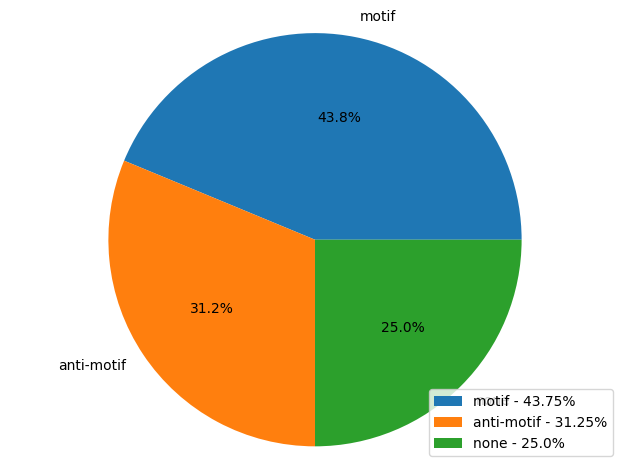

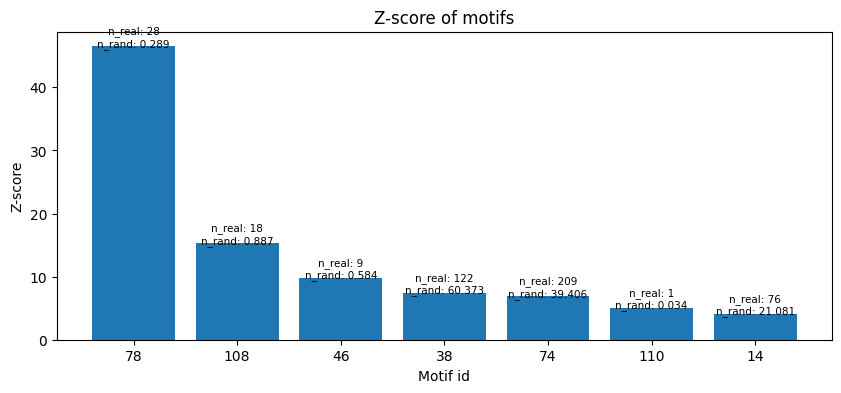

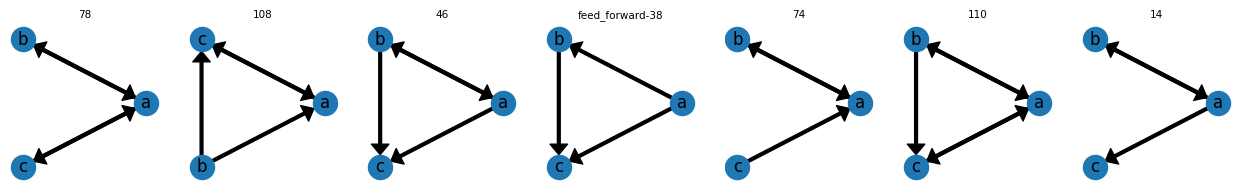

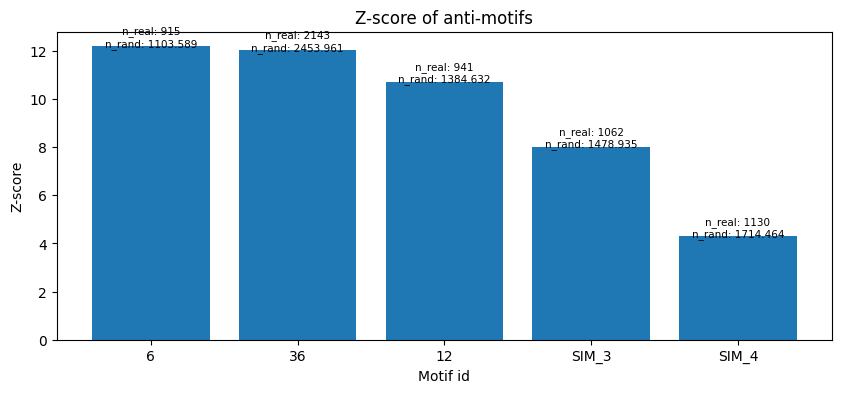

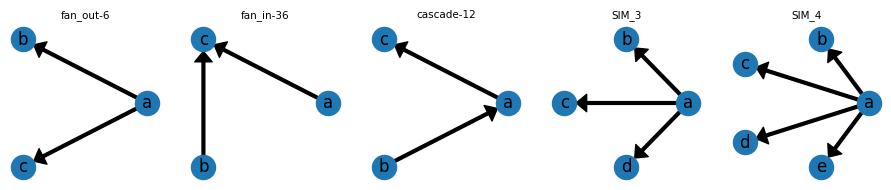

In [168]:
motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.none]

motifs_ = [m for m in motifs_ if m.n_real >= 1]
plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
plot_motifs_z(motifs_, MotifType.motif, top=10)
plot_motifs_z(anti_motifs_, MotifType.anti_motif, top=10)

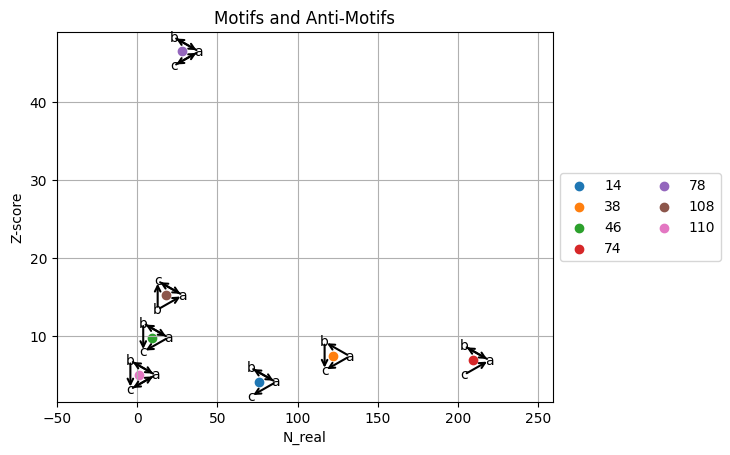

In [169]:
scatter_motifs(motifs_, True)

Node "AVAR" as role "" - sub graphs in Motif 14:
{'a': 'LUAR', 'c': 'AVAL', 'b': 'AVAR'}
{'a': 'LUAR', 'b': 'AVAR', 'c': 'AVDL'}
{'a': 'LUAR', 'b': 'AVAR', 'c': 'PVCR'}
{'a': 'LUAL', 'b': 'AVAL', 'c': 'AVAR'}
Node "AVAR" as role "" - sub graphs in Motif feed_forward-38:
{'a': 'ADAL', 'c': 'AVAR', 'b': 'AVJR'}
{'b': 'AVAR', 'c': 'AVDR', 'a': 'ADLL'}
{'a': 'AVJR', 'b': 'AVAR', 'c': 'AVDR'}
{'a': 'FLPL', 'b': 'AVAR', 'c': 'AVDR'}
{'a': 'FLPR', 'b': 'AVAR', 'c': 'AVDR'}
{'b': 'AVAR', 'c': 'AVDR', 'a': 'LUAL'}
{'b': 'AVAR', 'c': 'AVDR', 'a': 'PHBR'}
{'b': 'AVAR', 'c': 'AVDR', 'a': 'PQR'}
{'b': 'AVJR', 'c': 'AVAR', 'a': 'ADLL'}
{'b': 'FLPL', 'c': 'AVAR', 'a': 'FLPR'}
Node "AVAR" as role "" - sub graphs in Motif 46:
{'b': 'LUAR', 'a': 'AVAR', 'c': 'AVDR'}
Node "AVAR" as role "" - sub graphs in Motif 74:
{'c': 'ADAL', 'a': 'AVAR', 'b': 'LUAR'}
{'a': 'LUAR', 'b': 'AVAR', 'c': 'PHCR'}
{'b': 'LUAR', 'a': 'AVAR', 'c': 'ADAR'}
{'b': 'LUAR', 'a': 'AVAR', 'c': 'ADLL'}
{'b': 'LUAR', 'a': 'AVAR', 'c': 

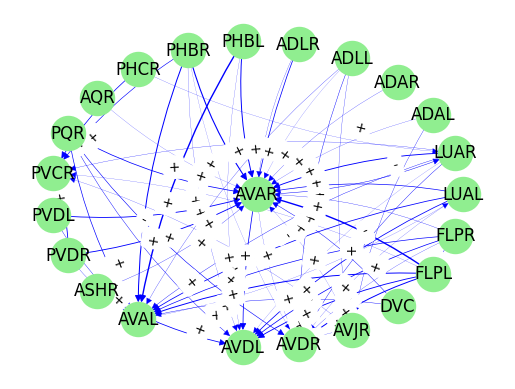

In [196]:
node = 'AVAR'
neighbors = []
for m in motifs_:
    neighbors.extend(get_node_neighbors_in_motif(node, m, role=''))
neighbors.append(node)
print(len(neighbors))
draw_sub_graph(network, neighbors, False, center=node)

['ADAL', 'ADAR', 'ADLL', 'ADLR', 'AQR', 'ASHR', 'AVJR', 'DVC', 'FLPL', 'FLPR', 'LUAL', 'LUAR', 'PHBL', 'PHBR', 'PQR', 'PVDL', 'PVDR', 'AVDR', 'LUAR']


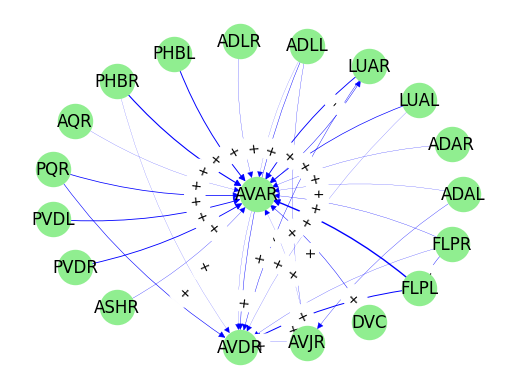

In [199]:
draw_neighbors(network, 'AVAR', 'all', False)

Polarity

motif: 23/147
anti-motif: 10/147
none: 114/147
Total number of SIM pol motifs: 15


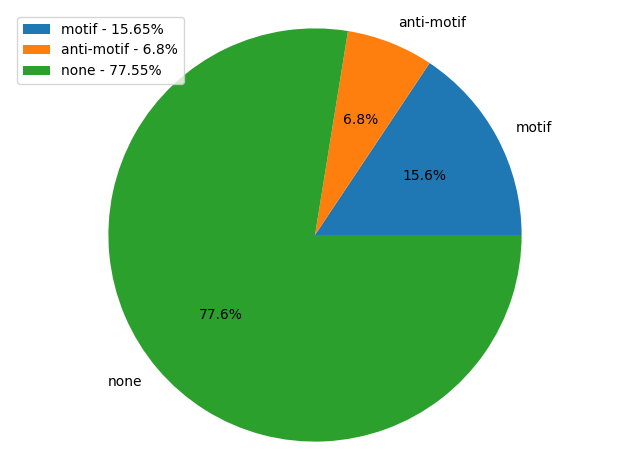

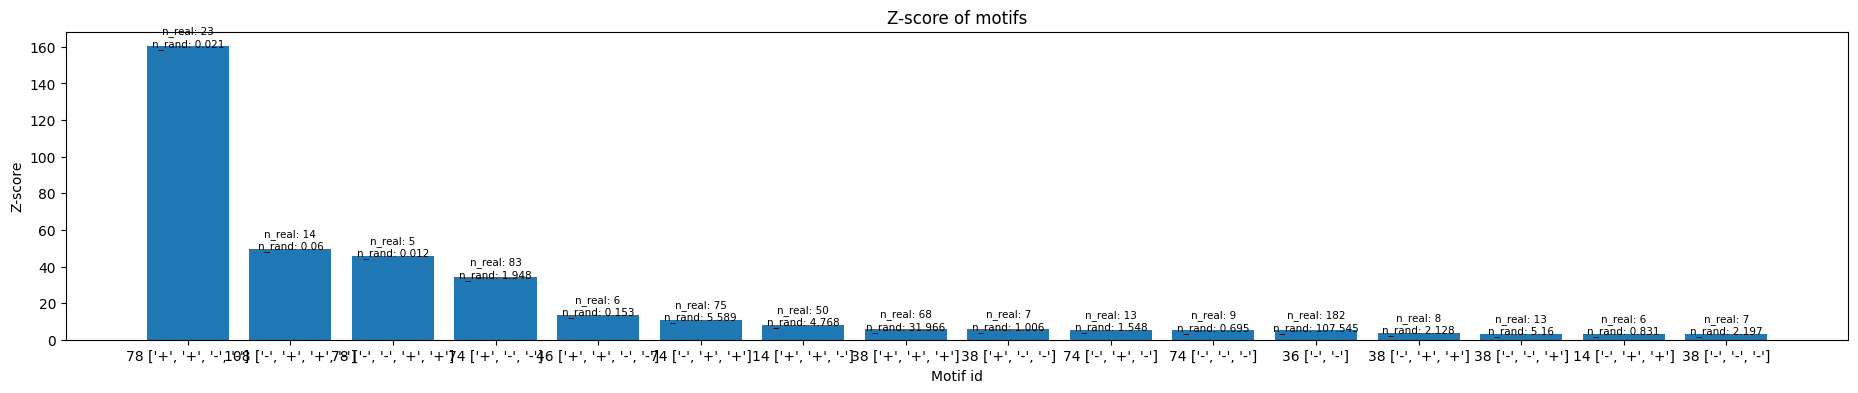

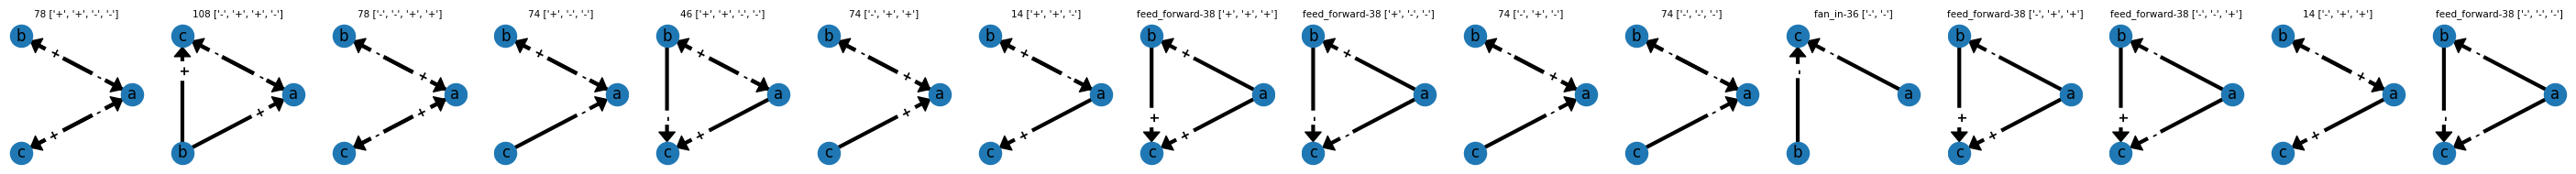

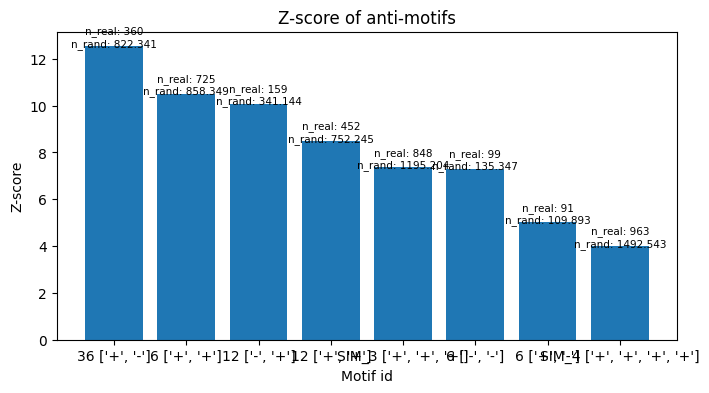

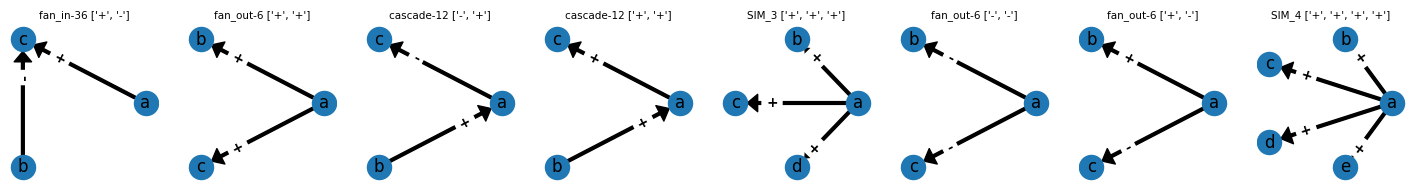

In [26]:
def count_sim_polarity_motifs(show_all = False):
    sim_pol_motifs_amount = 0
    for m in motifs:
        if not isinstance(m, int):
            sim_motif = motifs[m]
            sim_pol_motifs_amount += len(sim_motif.polarity_motifs)
            if show_all:
                print(len(sim_motif.polarity_motifs))
                print([sm.id for sm in sim_motif.polarity_motifs])
    
    print('Total number of SIM pol motifs:', sim_pol_motifs_amount)
    
al_polarities = []
for m in motifs.values():
    al_polarities.extend(m.polarity_motifs)

motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.none]

plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
count_sim_polarity_motifs()

motifs_ = [m for m in motifs_ if m.n_real >= 5]
plot_motifs_z(motifs_, MotifType.motif, top=23)
plot_motifs_z(anti_motifs_, MotifType.anti_motif, top=8)

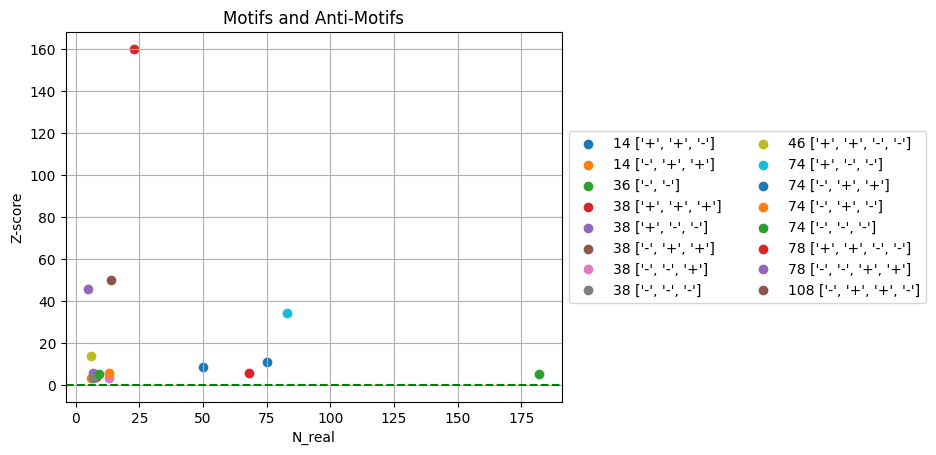

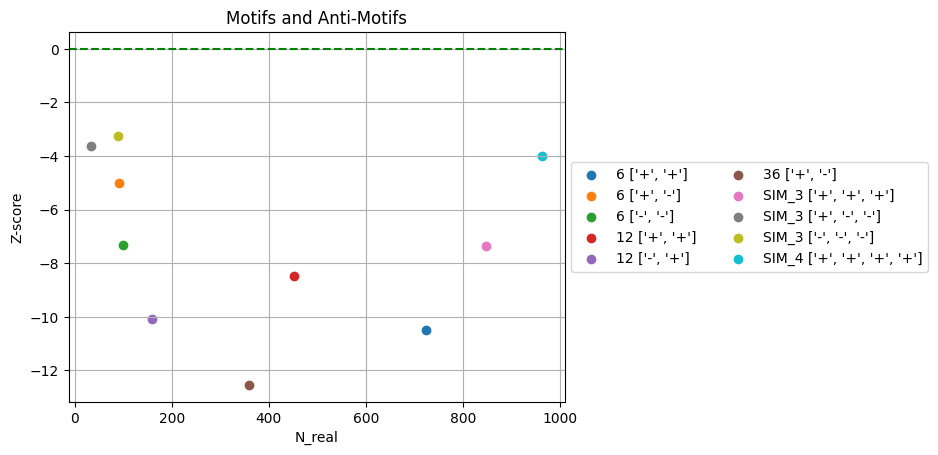

In [27]:
scatter_motifs(motifs_, False)
scatter_motifs(anti_motifs_, False)

In [16]:
# motif_ = motifs[6]
# polarity = ['+', '-']
# pol_idx = get_polarity_index(motif_, polarity)
# plot_motif_roles(motif_.polarity_motifs[pol_idx])

n_real=68 is_statistically_significant=True n_rand=31.966 z_score=5.839585235647968 std=6.17064372654912 p_value=2.616546910700339e-09 uniq=8 is_motif_frequent=True is_anti_motif_frequent=False is_uniq='n/a' is_motif=<MotifType.motif: 'motif'>


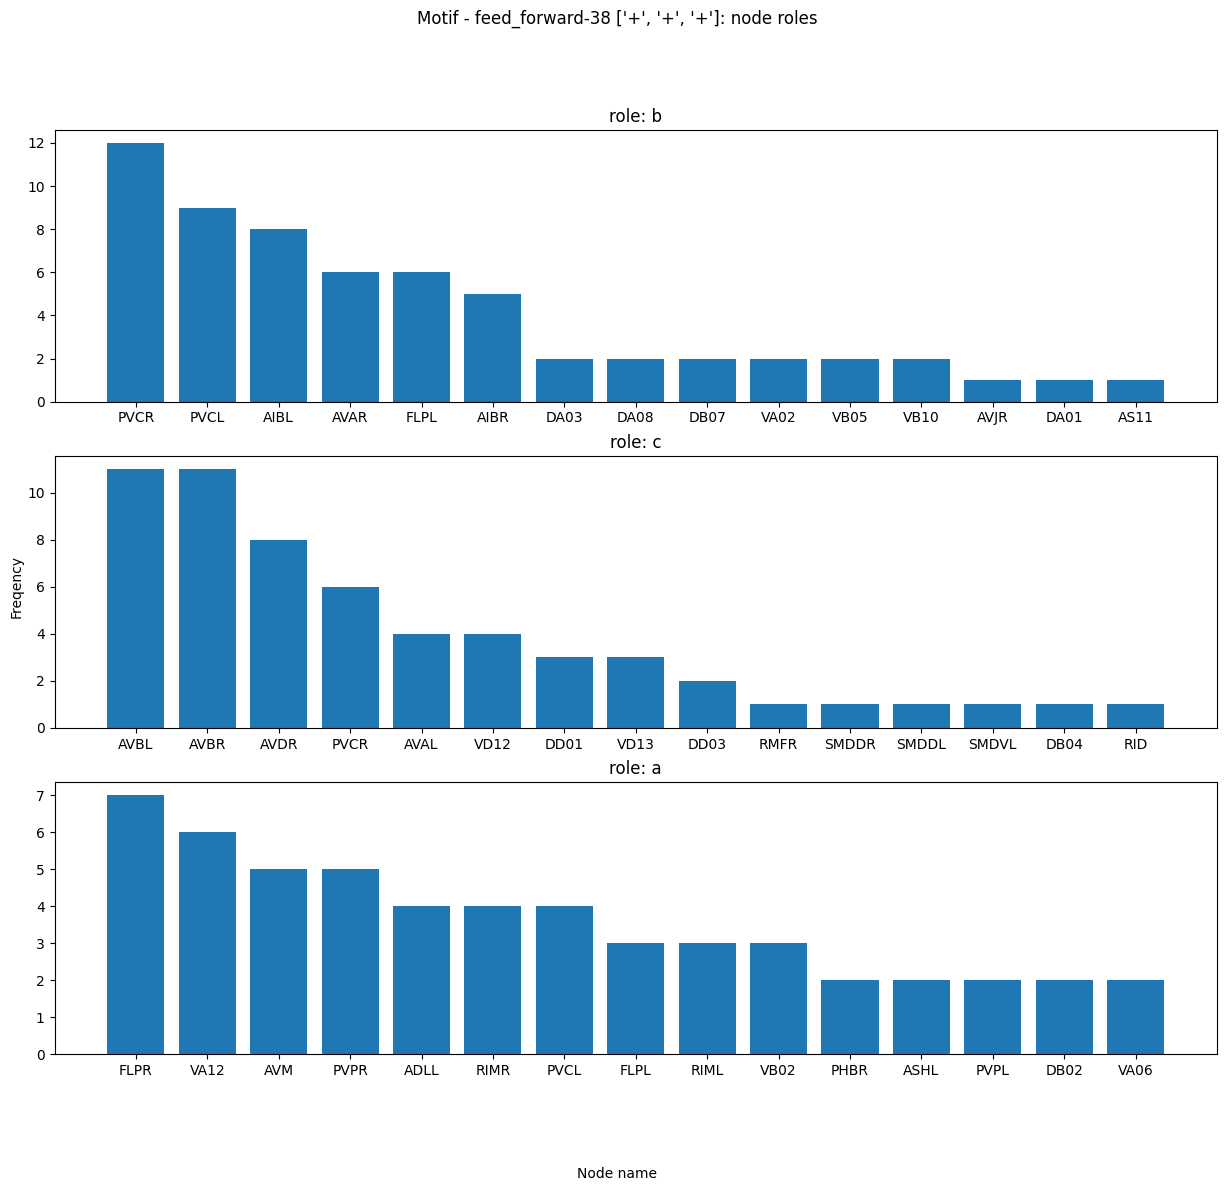

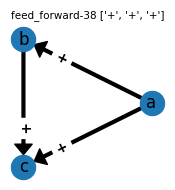

In [93]:
# k = 4
# motif_ = motifs[4428]
# polarity = ['-', '-', '-','+','+']

# motif_ = motifs[4374]
# polarity = ['+', '+', '-','-','-']

# motif_ = motifs[4678]
# polarity = ['+', '+', '-','-','-']

# motif_ = motifs[4424]
# polarity = ['+', '-','-','-']

# motif_ = motifs[4370]
# polarity = ['+', '-','-','-']

# motif_ = motifs[4436]
# polarity = ['-', '+', '+','-','+']

# motif_ = motifs[204]
# # polarity = ['-', '-', '-', '-']
# polarity = ['+', '-', '+', '-']
# polarity = ['+', '+', '+', '+']

# motif_ = motifs[904]
# polarity = ['+', '+', '-', '-']

# motif_ = motifs[206]
# polarity = ['+', '+', '+', '+', '+']

# motif_ = motifs[392]
# polarity = ['-','-','-']

# motif_ = motifs[404]
# polarity = ['-','+','+','+']

# motif_ = motifs[328]
# polarity = ['+','-','-']

# motif_ = motifs[2252]
# polarity = ['+', '+', '+', '+', '+']

# motif_ = motifs[2186]
# polarity = ['+', '+', '+', '+']

# motif_ = motifs[4420]
# polarity = ['-', '+', '-', '+']

# motif_ = motifs[344]
# polarity = ['+', '-', '-', '-']

# k = 3
motif_ = motifs[36]
polarity = ['-','-']

motif_ = motifs[38]
polarity = ['+','+', '+']
# polarity = ['-','-', '-']

# motif_ = motifs[74]
# polarity = ['+','-', '-']

# motif_ = motifs[108]
# polarity = ['-','+','+', '-']

pol_idx = get_polarity_index(motif_, polarity)
m = motif_.polarity_motifs[pol_idx]
print(m.motif_criteria)
plot_motif_roles(m, top=15)

{'b': 'AVAR', 'c': 'AVDR', 'a': 'ADLL'}
{'a': 'FLPL', 'b': 'AVAR', 'c': 'AVDR'}
{'a': 'FLPR', 'b': 'AVAR', 'c': 'AVDR'}
{'b': 'AVAR', 'c': 'AVDR', 'a': 'LUAL'}
{'b': 'AVAR', 'c': 'AVDR', 'a': 'PHBR'}
{'b': 'AVAR', 'c': 'AVDR', 'a': 'PQR'}
{'b': 'AVJR', 'c': 'AVDR', 'a': 'ADLL'}
{'b': 'AIBL', 'c': 'AVAL', 'a': 'ADLL'}
{'b': 'AIBL', 'c': 'AVBL', 'a': 'ADLL'}
{'a': 'ASHL', 'b': 'AIBL', 'c': 'AVAL'}
{'a': 'RIMR', 'b': 'AIBL', 'c': 'AVAL'}
{'a': 'ASHL', 'b': 'AIBL', 'c': 'AVBL'}
{'a': 'RIMR', 'b': 'AIBL', 'c': 'AVBL'}
{'a': 'RIMR', 'b': 'AIBL', 'c': 'RMFR'}
{'a': 'RIMR', 'b': 'AIBL', 'c': 'SMDDR'}
{'b': 'AIBR', 'c': 'AVBR', 'a': 'ADLR'}
{'a': 'ASHR', 'b': 'AIBR', 'c': 'AVBR'}
{'a': 'RIML', 'b': 'AIBR', 'c': 'AVBR'}
{'a': 'RIML', 'b': 'AIBR', 'c': 'SMDDL'}
{'a': 'RIML', 'b': 'AIBR', 'c': 'SMDVL'}
{'a': 'AVM', 'c': 'AVBL', 'b': 'PVCL'}
{'a': 'PVCL', 'c': 'AVBL', 'b': 'PVCR'}
{'b': 'PVCL', 'c': 'AVBL', 'a': 'PVPR'}
{'a': 'PVCL', 'c': 'AVBR', 'b': 'PVCR'}
{'b': 'PVCL', 'c': 'AVBR', 'a': 'AVM'}


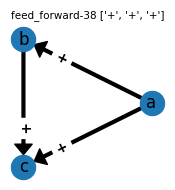

In [95]:
get_motif_sub_graphs(m)

Node "PVCR" as role "c" - sub graphs in Motif feed_forward-38 ['+', '+', '+']:
{'a': 'AVM', 'b': 'PVCL', 'c': 'PVCR'}
{'a': 'PHBR', 'b': 'PVCL', 'c': 'PVCR'}
{'a': 'PVDL', 'b': 'PVCL', 'c': 'PVCR'}
{'a': 'PVDR', 'b': 'PVCL', 'c': 'PVCR'}
{'b': 'PVCL', 'c': 'PVCR', 'a': 'PVPR'}
{'b': 'LUAR', 'c': 'PVCR', 'a': 'PHCR'}


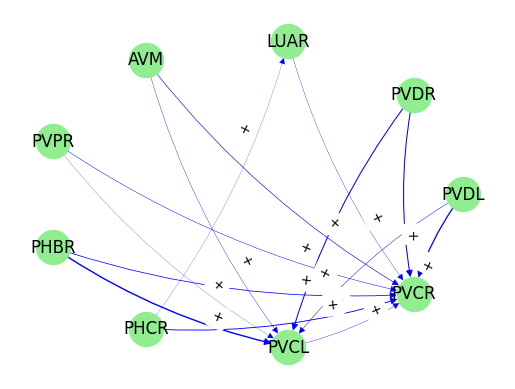

In [167]:
neighbors = get_node_neighbors_in_motif('PVCR', m, role='c')
neighbors.append('PVCR')
draw_sub_graph(network, neighbors, False)

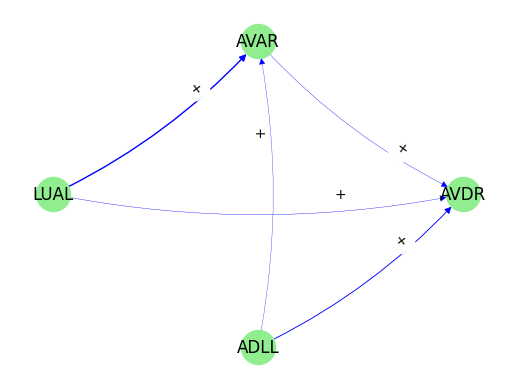

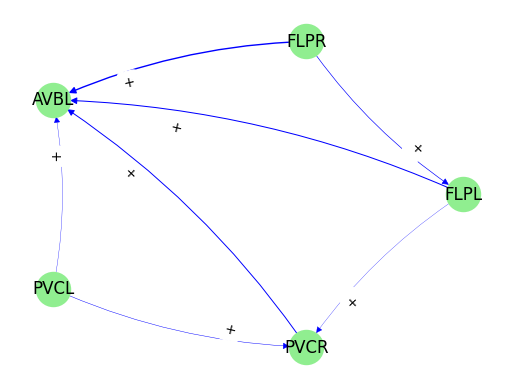

In [94]:
# k=3 ffls
draw_sub_graph(network, ['AVDR', 'ADLL', 'LUAL', 'AVAR'], False)
draw_sub_graph(network, ['AVBL', 'PVCL', 'PVCR', 'FLPR', 'FLPL'], False)


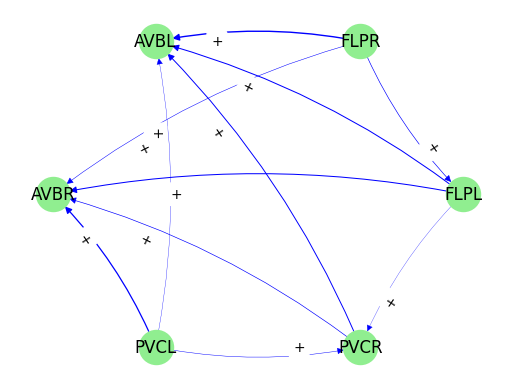

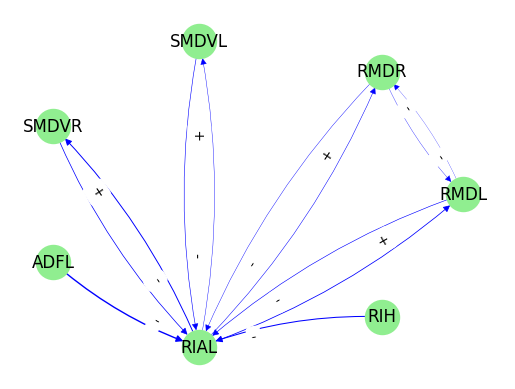

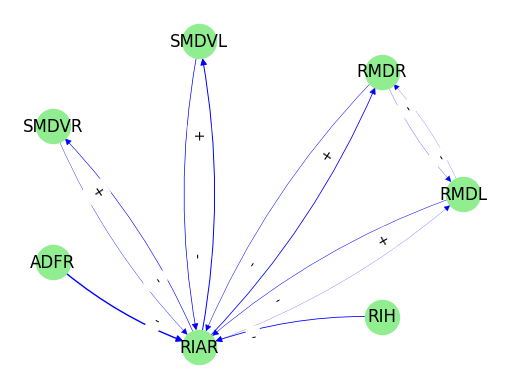

In [34]:
#expansion of ffl
draw_sub_graph(network, ['PVCL', 'PVCR', 'FLPL', 'FLPR', 'AVBL', 'PVCL', 'AVBR'], False)

draw_sub_graph(network, ['SMDVR', 'RIAL', 'ADFL', 'SMDVL', 'RMDR', 'RMDL', 'RIH'], False)
draw_sub_graph(network, ['SMDVR', 'RIAR', 'ADFR', 'SMDVL', 'RMDR', 'RMDL', 'RIH'], False)


In [ ]:
# motif_ = motifs[78]
# polarity = ['+', '+', '-', '-']
# # polarity = ['complex', '-', 'complex', '+']
# pol_idx = get_polarity_index(motif_, polarity)
# plot_motif_roles(motif_.polarity_motifs[pol_idx], top=6)

In [ ]:
# get_motif_sub_graphs(motif_.polarity_motifs[pol_idx])

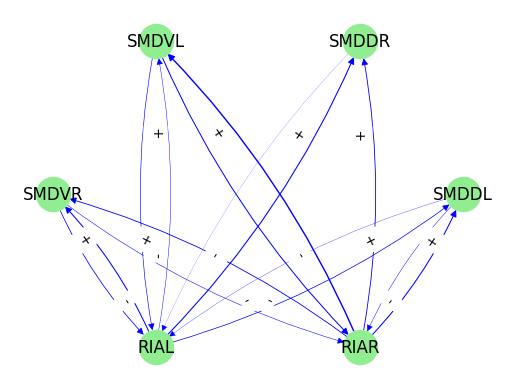

In [35]:
draw_sub_graph(network, ['RIAL', 'SMDVL', 'SMDVR', 'SMDDL', 'SMDDR', 'RIAR'], False)

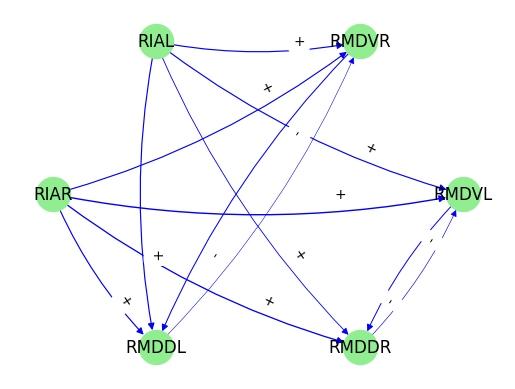

In [36]:
draw_sub_graph(network, ['RIAL', 'RIAR', 'RMDDR', 'RMDVR', 'RMDDL', 'RMDVL'], False)

['DA01', 'DA02', 'DA03', 'VA01']
['AIZR', 'ALA', 'AUAL', 'AVDL', 'BAGR', 'DVA', 'FLPR', 'OLLR', 'PVCR', 'PVNR', 'RIBL', 'RIBR', 'RIGL', 'RIS', 'URXL', 'URYDR', 'URYVL', 'URYVR']


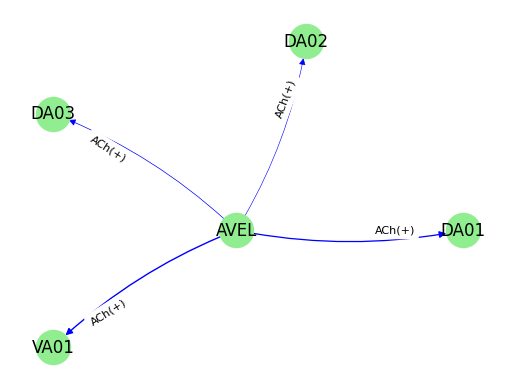

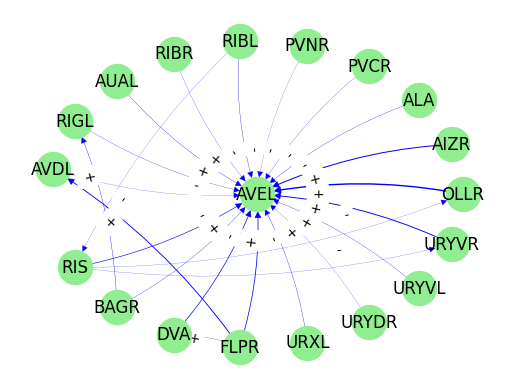

In [81]:
draw_neighbors(network, 'AVEL', 'out', True)
draw_neighbors(network, 'AVEL', 'in', False)

Node RIAL properties:
Degree: 25
Out Degree: 10
In Degree: 15
Clustering coefficient: 0.043


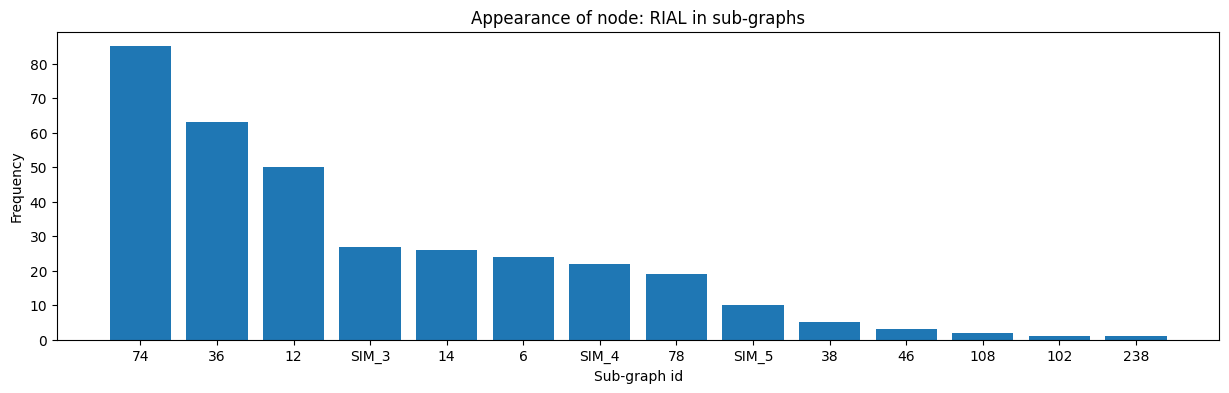

In [90]:
node_props('RIAL')